In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=36ad21dc8b8db80c1f16cb949be95205b12f2d804e1df498a4e103cf4cf4a947
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


Initial state of qubit 0:


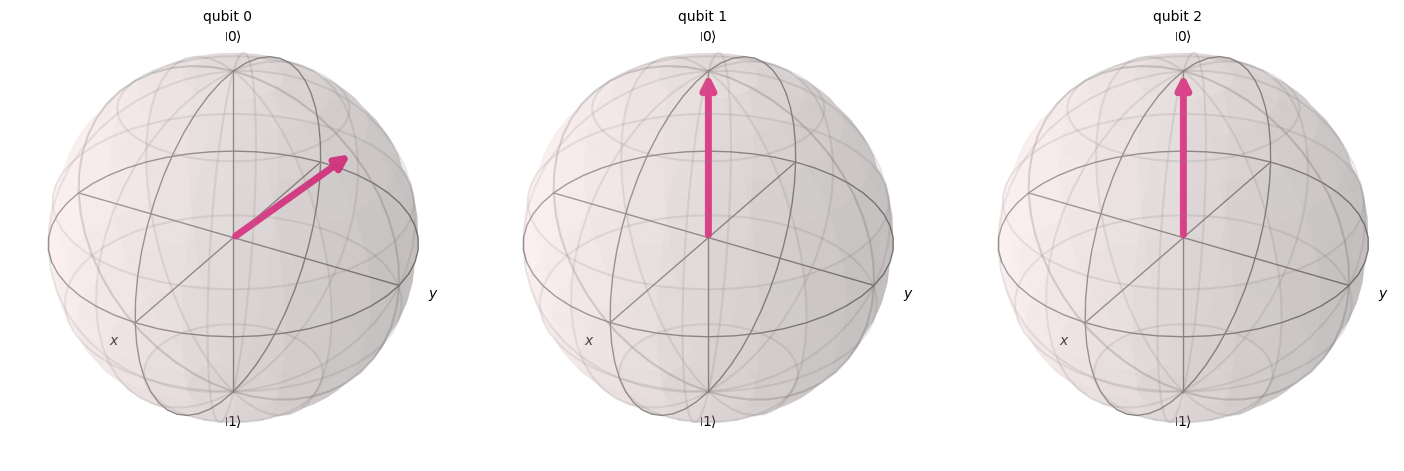

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


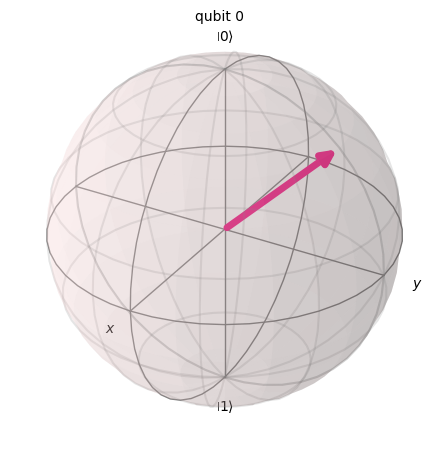

In [ ]:

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# Define theta and phi here
theta = np.pi/4  # Example value: pi/4
phi = np.pi/2 # Example value: pi/2

# 1️⃣ Build the teleportation circuit
qc = QuantumCircuit(3)

# Prepare arbitrary state on qubit 0
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement part (but coherent)
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

# Save final statevector explicitly (Qiskit 2.x requires this)
qc.save_statevector()

# 2️⃣ Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

# 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Extract the dominant pure states (since both should be pure)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Compute fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

# 4️⃣ Visualize Bloch spheres (fixed)
print("\nBob’s final qubit (qubit 2) Bloch vector:")

# Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
bob_sv = Statevector(bob_state)

display(plot_bloch_multivector(bob_sv))

In [ ]:
# Task 2: Add Classical Measurement
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np

# Define theta and phi
theta = np.pi/4
phi = np.pi/2

# Build the teleportation circuit with classical measurements
qc_measured = QuantumCircuit(3, 2) # 3 qubits, 2 classical bits

# Prepare arbitrary state |ψ⟩ on qubit 0
qc_measured.ry(theta, 0)
qc_measured.rz(phi, 0)

# Create Bell pair between qubits 1 and 2
qc_measured.h(1)
qc_measured.cx(1, 2)

# Bell measurement
qc_measured.cx(0, 1)
qc_measured.h(0)

# Measure qubits 0 and 1
qc_measured.measure([0, 1], [0, 1])

# Conditional corrections using classical bits
# Note: .c_if() is the Qiskit 2.x way to apply conditional operations
qc_measured.barrier() # Optional barrier for clarity
# Apply X gate on qubit 2 if classical bit 1 is 1
with qc_measured.if_test((qc_measured.clbits[1], 1)):
    qc_measured.x(2)
# Apply Z gate on qubit 2 if classical bit 0 is 1
with qc_measured.if_test((qc_measured.clbits[0], 1)):
    qc_measured.z(2)


# Simulate
sim = AerSimulator()
compiled = transpile(qc_measured, sim)
result = sim.run(compiled, shots=1024).result()
counts = result.get_counts(compiled)

print("Measurement results:", counts)


Measurement results: {'01': 266, '00': 274, '10': 236, '11': 248}


Average fidelity over 20 random states: 1.000000


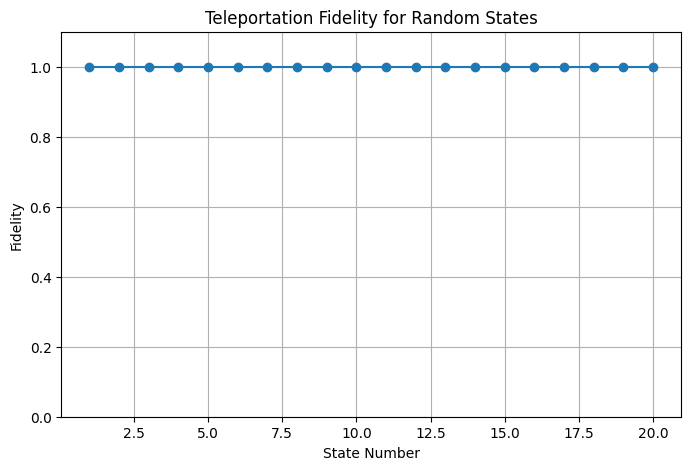

In [ ]:
# Task 3: Fidelity Analysis
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np
import matplotlib.pyplot as plt

sim = AerSimulator()
fidelities = []
num_states = 20

for _ in range(num_states):
    # Generate random theta and phi
    theta = 2 * np.pi * np.random.rand()
    phi = 2 * np.pi * np.random.rand()

    # Build the teleportation circuit
    qc = QuantumCircuit(3)

    # Prepare arbitrary state |ψ⟩ on qubit 0
    qc.ry(theta, 0)
    qc.rz(phi, 0)

    # Save initial state for comparison
    sv_initial = Statevector.from_instruction(qc)

    # Create Bell pair between qubits 1 and 2
    qc.h(1)
    qc.cx(1, 2)

    # Bell measurement part (coherent)
    qc.cx(0, 1)
    qc.h(0)

    # Coherent corrections
    qc.cx(1, 2)
    qc.cz(0, 2)

    # Save final statevector
    qc.save_statevector()

    # Simulate
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()

    # Retrieve the saved statevector
    sv_final = result.data(0)["statevector"]
    sv_final = Statevector(sv_final)

    # Compare: initial vs Bob’s (qubit 2) final state
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_initial, [1, 2])

    # Extract the dominant pure states
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]

    # Compute fidelity
    fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
    fidelities.append(fidelity)

print(f"Average fidelity over {num_states} random states: {np.mean(fidelities):.6f}")

# Plot fidelity values
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_states + 1), fidelities, marker='o', linestyle='-')
plt.xlabel("State Number")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity for Random States")
plt.grid(True)
plt.ylim(0, 1.1)
plt.show()

Step-by-Step Bloch Sphere Visualization:

State after 'initial':


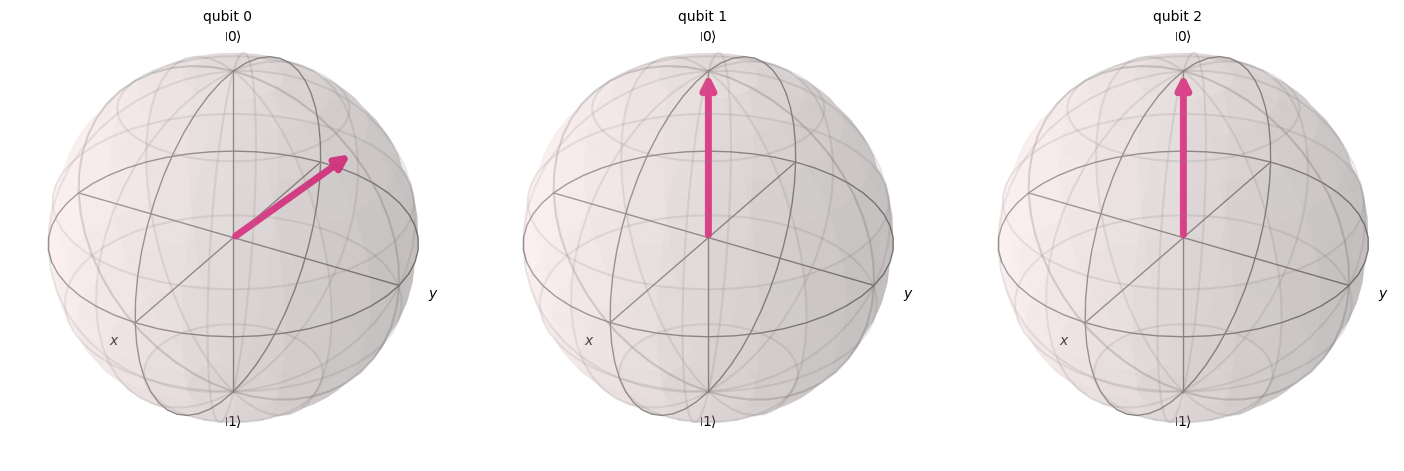


State after 'bell_pair':


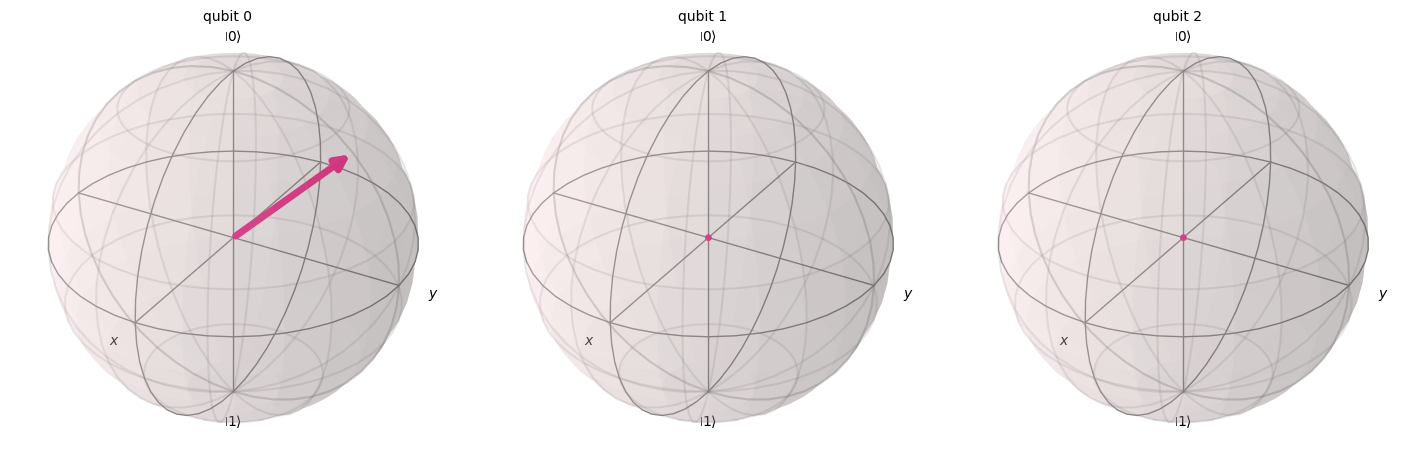


State after 'bell_measurement':


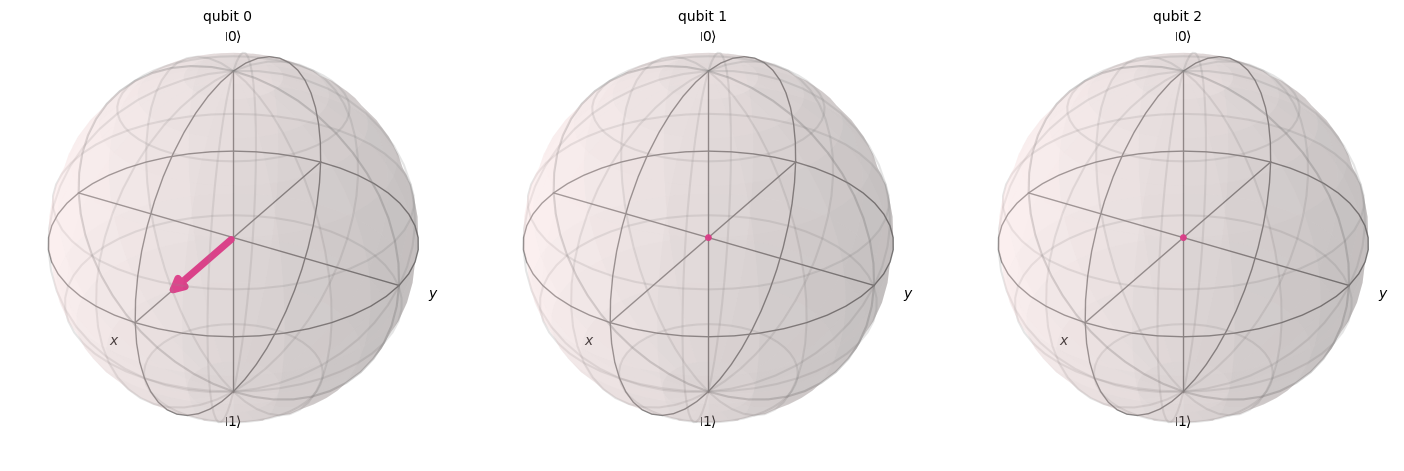


State after 'final':


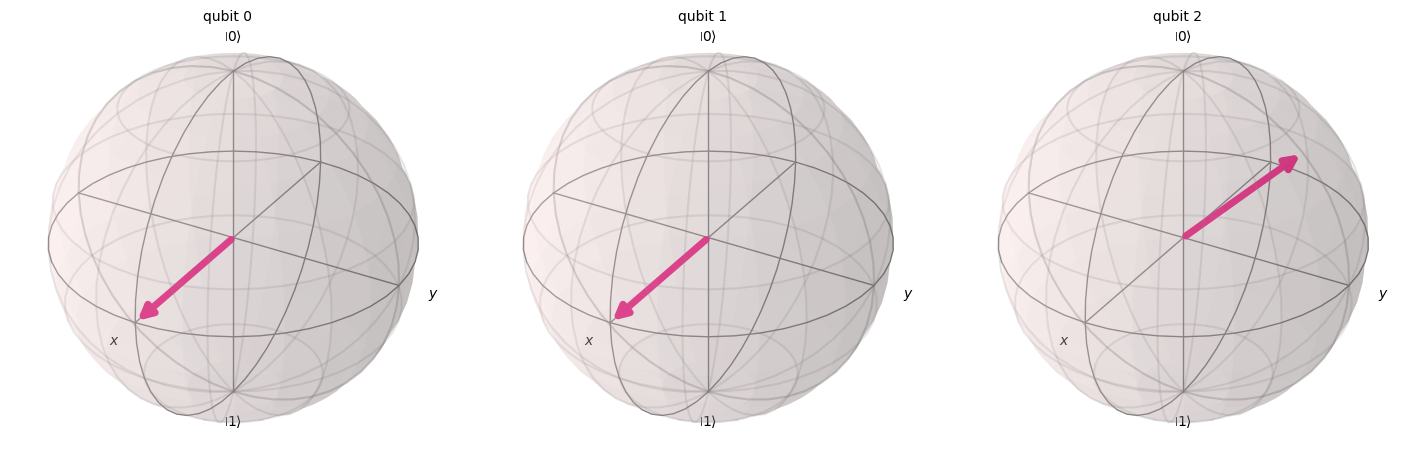

In [ ]:
# Task 4: Step-by-Step Visualization
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Define theta and phi
theta = np.pi/4
phi = np.pi/2

# Build the teleportation circuit with intermediate state saving
qc = QuantumCircuit(3)

# List to store intermediate statevectors for visualization
intermediate_states = []

# Initial state preparation and save
qc.ry(theta, 0)
qc.rz(phi, 0)
qc.save_statevector(label="initial")
intermediate_states.append("initial")

# Create Bell pair and save
qc.h(1)
qc.cx(1, 2)
qc.save_statevector(label="bell_pair")
intermediate_states.append("bell_pair")

# Bell measurement part (coherent) and save
qc.cx(0, 1)
qc.h(0)
qc.save_statevector(label="bell_measurement")
intermediate_states.append("bell_measurement")


# Coherent corrections and save
qc.cx(1, 2)
qc.cz(0, 2)
qc.save_statevector(label="final")
intermediate_states.append("final")

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve and display intermediate statevectors
print("Step-by-Step Bloch Sphere Visualization:")
for label in intermediate_states:
    sv = result.data(0)[label]
    sv = Statevector(sv)
    print(f"\nState after '{label}':")
    display(plot_bloch_multivector(sv))
    # You might want to add a small delay or user input here
    # if you want to view each step individually before proceeding.
    # import time
    # time.sleep(2)
    # clear_output(wait=True)

Fidelity between initial and teleported states with noise (p=0.05): 0.500000

Bob’s final qubit (qubit 2) Bloch vector with noise:


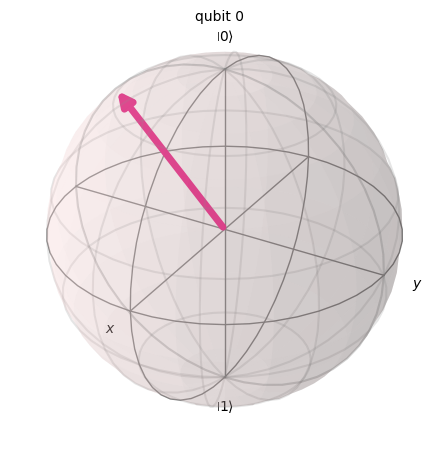

In [ ]:
# Task 5: Introduce Noise
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_bloch_multivector 


theta = np.pi/4
phi = np.pi/2


qc = QuantumCircuit(3)

# Prepare arbitrary state |ψ⟩ on qubit 0
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement part
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

# Save final statevector
qc.save_statevector()

# Create a simple depolarizing noise model
noise_model = NoiseModel()
# Add a depolarizing error to all single qubit gates
p_depol = 0.05  # Probability of depolarizing error
noise_model.add_all_qubit_quantum_error(depolarizing_error(p_depol, 1),
                                        ['rz', 'ry', 'h'])
# Add a depolarizing error to all two qubit gates
noise_model.add_all_qubit_quantum_error(depolarizing_error(p_depol, 2),
                                        ['cx', 'cz'])
# Simulate with noise
sim_noise = AerSimulator(noise_model=noise_model)
compiled_noise = transpile(qc, sim_noise)
result_noise = sim_noise.run(compiled_noise).result()

# Retrieve the saved statevector from noisy simulation
sv_final_noise = result_noise.data(0)["statevector"]
sv_final_noise = Statevector(sv_final_noise)

# Compare: initial vs Bob’s (qubit 2) final state with noise
rho_bob_noise = partial_trace(sv_final_noise, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2]) # Initial state is noise-free

# Extract the dominant pure states (assuming dominant state is still close to pure)
eigvals_b_noise, eigvecs_b_noise = np.linalg.eigh(rho_bob_noise.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state_noise = eigvecs_b_noise[:, np.argmax(eigvals_b_noise)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]


# Compute fidelity with noise
fidelity_noise = np.abs(np.vdot(init_state, bob_state_noise)) ** 2
print(f"Fidelity between initial and teleported states with noise (p={p_depol}): {fidelity_noise:.6f}")

# Visualize Bob's final qubit with noise
print("\nBob’s final qubit (qubit 2) Bloch vector with noise:")
bob_sv_noise = Statevector(bob_state_noise)
display(plot_bloch_multivector(bob_sv_noise))